# Who Will Pay the Loan?
## *A machine learning approach to identify good customers*

In [2]:
import pandas as pd
import numpy as np
import pylab as pl
%matplotlib inline
import seaborn as sns

In [48]:
pl.rcParams['figure.figsize'] = (8, 6)  # set figure size
pl.rcParams['figure.dpi'] = 100
pl.rc('font', size=10)

## Part A: Exploratory Data Analysis
### 1. General information of dataset

In [4]:
# read data from csv to dataframe
data = pd.read_csv('LoanStats3c.csv', header=0, low_memory=False)

In [5]:
print('Number of data samples: %s' % data.shape[0])
print('Number of data features: %s' % data.shape[1])

Number of data samples: 161231
Number of data features: 52


In [6]:
if len(data) == len(data.id.unique()):
    print("All the data samples have unique id.")

All the data samples have unique id.


In [7]:
# percentages of missing values
miss_percents = data.isnull().mean().sort_values(ascending=False)

# top 10 features that have the most missing values
miss_percents.head(10)

desc                           0.905744
mths_since_last_record         0.820574
mths_since_last_major_derog    0.719812
mths_since_last_delinq         0.497566
emp_title                      0.056956
next_pymnt_d                   0.045413
last_pymnt_d                   0.000688
revol_util                     0.000521
last_credit_pull_d             0.000081
home_ownership                 0.000000
dtype: float64

In [8]:
# remove features with missing values
miss_features = list(miss_percents.index[miss_percents > 0])
data.drop(miss_features, axis=1, inplace=True)

In [9]:
data.shape

(161231, 43)

### 2. Descriptive statistics of 3 features: loan_amnt, int_rate, grade

In [10]:
data.loan_amnt.describe()

count    161231.000000
mean      14864.642190
std        8412.637516
min        1000.000000
25%        8400.000000
50%       13000.000000
75%       20000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

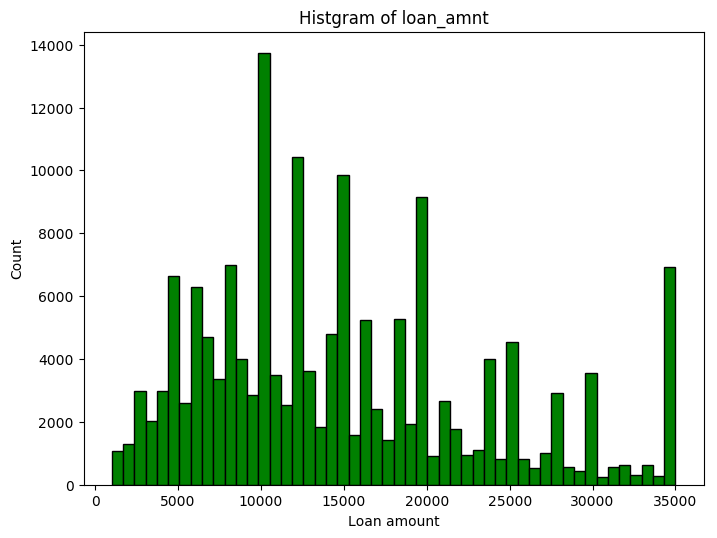

In [49]:
_ = pl.hist(data.loan_amnt, bins=50, color='green', edgecolor='black')
pl.xlabel('Loan amount')
pl.ylabel('Count')
pl.title('Histgram of loan_amnt')

In [15]:
# convert int_rate to numeric
data.int_rate = data.int_rate.apply(lambda x: float(x[:-1]))

In [16]:
data.int_rate.describe()

count    161231.000000
mean         14.057480
std           4.326685
min           6.000000
25%          10.990000
50%          13.980000
75%          16.590000
max          26.060000
Name: int_rate, dtype: float64

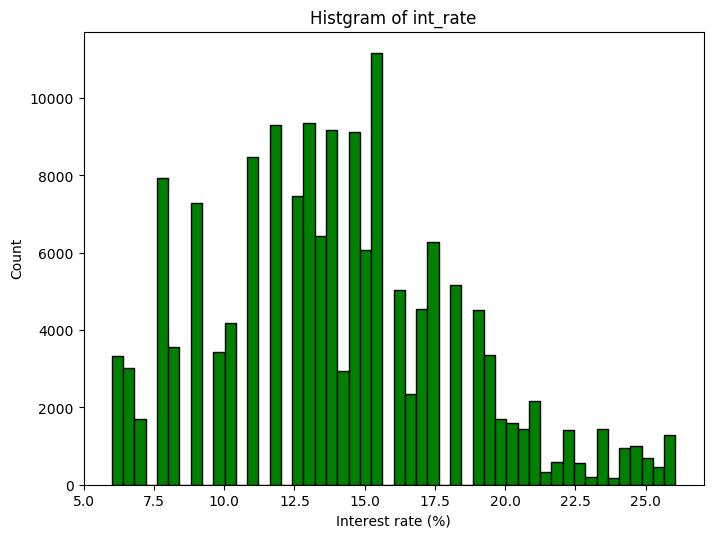

In [17]:
_ = pl.hist(data.int_rate, bins=50, color='green', edgecolor='black')
pl.xlabel('Interest rate (%)')
pl.ylabel('Count')
pl.title('Histgram of int_rate')

In [18]:
# grade is categorical data
data.grade.describe()

count     161231
unique         7
top            C
freq       45257
Name: grade, dtype: object

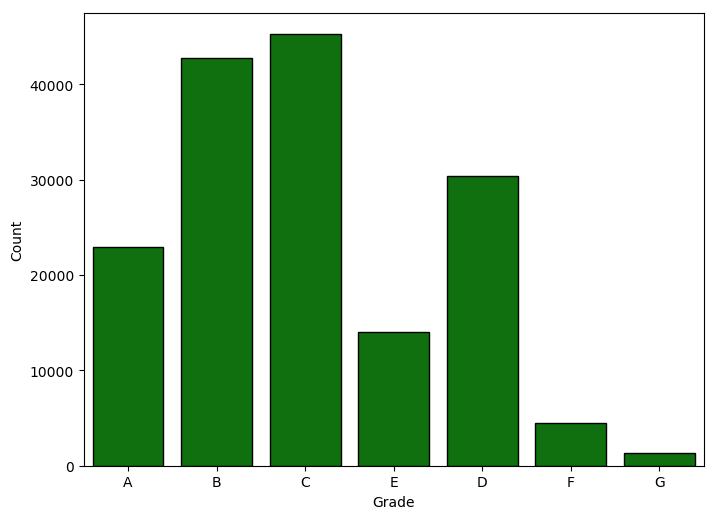

In [19]:
ax = sns.countplot(data.grade, color='green', edgecolor='black')
pl.xlabel('Grade')
pl.ylabel('Count')

### 3. Proposed business problem

In [20]:
loan_status = data.loan_status.copy()

In [21]:
loan_status.value_counts()

Current               151208
Fully Paid              6922
Late (31-120 days)      1362
In Grace Period          853
Late (16-30 days)        409
Charged Off              400
Default                   76
Issued                     1
Name: loan_status, dtype: int64

### 4. Features related to the proposed business problem

In [22]:
# create a new dataframe
df = data[(data.loan_status == 'Fully Paid') | (data.loan_status == 'Charged Off')]
df = df[['loan_amnt', 'int_rate', 'term', 'grade', 'loan_status']].copy()
df.index = range(len(df))

In [24]:
df.head()

,loan_amnt,int_rate,term,grade,loan_status
0,10000,16.99,36 months,D,Fully Paid
1,28750,9.17,60 months,B,Fully Paid
2,17000,6.49,36 months,A,Fully Paid
3,8025,18.24,36 months,D,Fully Paid
4,20000,11.67,60 months,B,Fully Paid


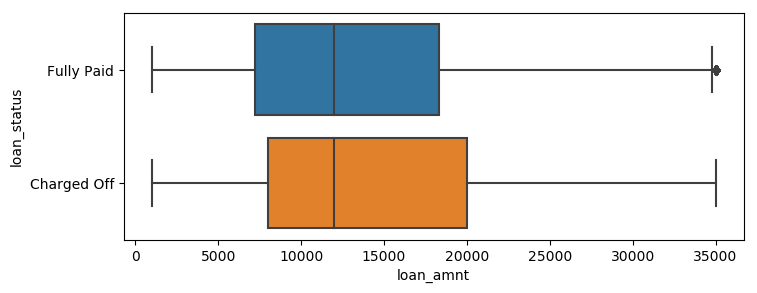

In [25]:
# box plot: loan_amnt vs loan_status
pl.figure(figsize=(8, 3))
sns.boxplot(x='loan_amnt', y='loan_status', data=df)

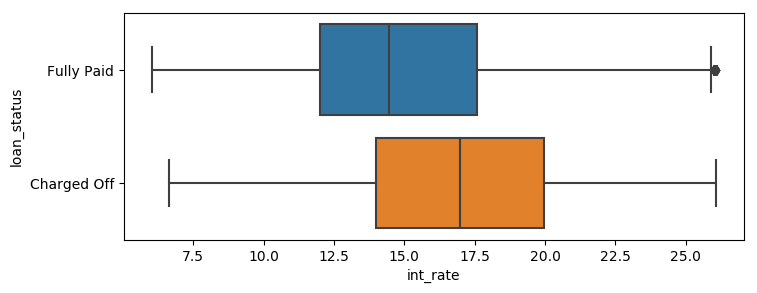

In [26]:
# box plot: int_rate vs loan_status
pl.figure(figsize=(8, 3))
sns.boxplot(x='int_rate', y='loan_status', data=df)

In [27]:
# term statistics
print('Number of 36 months loans: %s' % len(df[df.term == ' 36 months']))
print('Number of 36 months fully paid loans: %s' % len(df[(df.term == ' 36 months') & (df.loan_status == 'Fully Paid')]))
print('Number of 36 months charged off loans: %s' % len(df[(df.term == ' 36 months') & (df.loan_status == 'Charged Off')]))
print('\n')
print('Number of 60 months loans: %s' % len(df[df.term == ' 60 months']))
print('Number of 60 months fully paid loans: %s' % len(df[(df.term == ' 60 months') & (df.loan_status == 'Fully Paid')]))
print('Number of 60 months charged off loans: %s' % len(df[(df.term == ' 60 months') & (df.loan_status == 'Charged Off')]))

Number of 36 months loans: 5238
Number of 36 months fully paid loans: 4972
Number of 36 months charged off loans: 266


Number of 60 months loans: 2084
Number of 60 months fully paid loans: 1950
Number of 60 months charged off loans: 134


In [28]:
def convert_category(alist):
    uniques = sorted(list(set(alist)))
    return [uniques.index(x) + 1 for x in alist]

In [29]:
# convert to nuemrical
df.grade = convert_category(df.grade.tolist())

([<matplotlib.axis.XTick at 0x262bdf75898>,
 <a list of 7 Text xticklabel objects>)

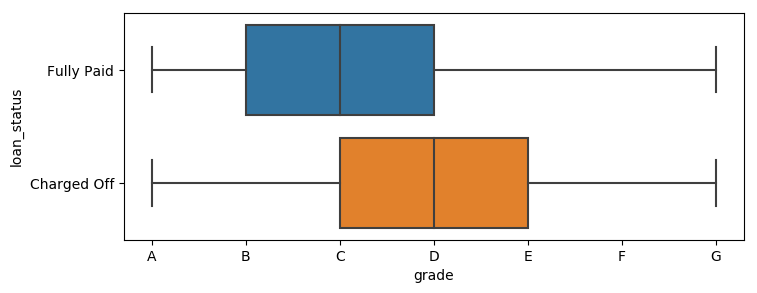

In [30]:
# box plot: int_rate vs loan_status
pl.figure(figsize=(8, 3))
sns.boxplot(x='grade', y='loan_status', data=df)
pl.xticks(range(1, 8), ['A', 'B', 'C', 'D', 'E', 'F', 'G'])

## Part B: Feature Engineering and Modelling
### 1. Machine learning model

In [31]:
# Focus on fully paid and charged off loans
dataset = data[(data.loan_status == 'Fully Paid') | (data.loan_status == 'Charged Off')].copy()

In [32]:
# After removing the features with missing values, there are 43 remaining
dataset.shape

(7322, 43)

In [33]:
# funded_amnt is redundant
if sum(dataset.loan_amnt == dataset.funded_amnt) == len(dataset):
    print('funded_amt is redundant.')

funded_amt is redundant.


In [34]:
# Selected features
cols = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length',
       'home_ownership', 'annual_inc', 'is_inc_v', 'loan_status', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc', 'revol_bal',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'last_pymnt_amnt']

In [35]:
loan = dataset[cols].copy()

In [36]:
loan.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,is_inc_v,...,inq_last_6mths,open_acc,pub_rec,total_acc,revol_bal,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt
252,10000,36 months,16.99,356.48,D,D3,7 years,MORTGAGE,86000.0,Source Verified,...,1,16,1,55,26855,10141.59,10141.59,10000.0,141.59,10141.59
490,28750,60 months,9.17,599.18,B,B1,n/a,MORTGAGE,59736.0,Verified,...,0,11,0,29,56838,28969.70,28969.70,28750.0,219.70,28969.70
631,17000,36 months,6.49,520.96,A,A2,< 1 year,MORTGAGE,129996.0,Not Verified,...,1,8,0,21,7845,17100.91,17075.76,17000.0,100.91,17100.91
636,8025,36 months,18.24,291.10,D,D5,10+ years,OWN,68000.0,Verified,...,1,11,0,16,9134,8146.98,8146.98,8025.0,121.98,8146.98
794,20000,60 months,11.67,441.57,B,B4,4 years,MORTGAGE,100000.0,Source Verified,...,1,11,0,34,11481,20194.50,20194.50,20000.0,194.50,20194.50


#### 1.1 Feature engineering

In [37]:
def convert_status(x):
    """
    0 - Fully Paid
    1 - Charged Off
    
    """
    
    if x == 'Fully Paid':
        return 0
    else:
        return 1
    
def convert_term(x):
    """
    0 - 36 months
    1 - 60 months
    
    """
    
    if x.startswith(' 36'):
        return 0
    else:
        return 1

def convert_length(x):
    """
    0 - < 1year and n/a
    1 - 1 year
    2 - 2 years
    3 - 3 years
    4 - 4 years
    5 - 5 years
    6 - 6 years
    7 - 7 years
    8 - 8 years
    9 - 9 years
    10 - 10+ years
    
    """
    
    if x[0] in '123456789':
        if x.startswith('10+'):
            return 10
        else:
            return int(x[0])
    else:
        return 0

def convert_ownership(x):
    """
    0 - mortgage, own
    1 - rent, any
    
    """
    
    if x in ['MORTGAGE', 'OWN']:
        return 0
    else:
        return 1

def convert_verified(x):
    """
    0 - Source Verified, Verified           
    1 - Not Verified       

    """
    if x == 'Not Verified':
        return 1
    else:
        return 0

In [38]:
# convert categorical data to numeric
loan.term = loan.term.apply(convert_term)
loan.grade = convert_category(loan.grade.tolist())
loan.sub_grade = convert_category(loan.sub_grade.tolist())
loan.emp_length = loan.emp_length.apply(convert_length)
loan.home_ownership = loan.home_ownership.apply(convert_ownership)
loan.is_inc_v = loan.is_inc_v.apply(convert_verified)
loan.loan_status = loan.loan_status.apply(convert_status)

In [41]:
loan.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,is_inc_v,...,inq_last_6mths,open_acc,pub_rec,total_acc,revol_bal,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt
252,10000,0,16.99,356.48,4,18,7,0,86000.0,0,...,1,16,1,55,26855,10141.59,10141.59,10000.0,141.59,10141.59
490,28750,1,9.17,599.18,2,6,0,0,59736.0,0,...,0,11,0,29,56838,28969.70,28969.70,28750.0,219.70,28969.70
631,17000,0,6.49,520.96,1,2,0,0,129996.0,1,...,1,8,0,21,7845,17100.91,17075.76,17000.0,100.91,17100.91
636,8025,0,18.24,291.10,4,20,10,0,68000.0,0,...,1,11,0,16,9134,8146.98,8146.98,8025.0,121.98,8146.98
794,20000,1,11.67,441.57,2,9,4,0,100000.0,0,...,1,11,0,34,11481,20194.50,20194.50,20000.0,194.50,20194.50


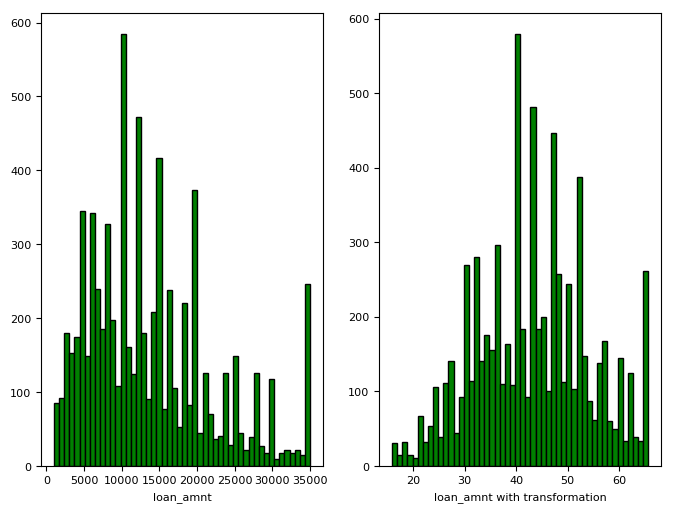

In [42]:
f, (ax1, ax2) = pl.subplots(nrows=1, ncols=2)
_ = ax1.hist(loan.loan_amnt, bins=50, color='green', edgecolor='black')
_ = ax2.hist(loan.loan_amnt ** 0.4, bins=50, color='green', edgecolor='black')
ax1.set_xlabel('loan_amnt', fontsize=8)
ax2.set_xlabel('loan_amnt with transformation', fontsize=8)
ax1.tick_params(axis='both', labelsize=8)
ax2.tick_params(axis='both', labelsize=8)

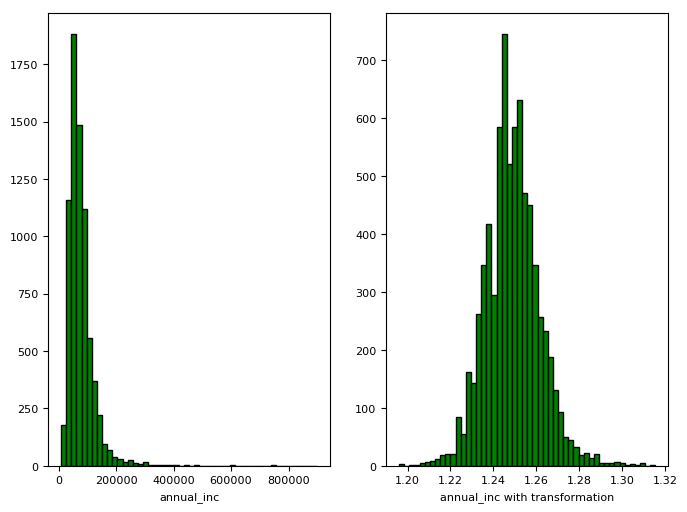

In [43]:
f, (ax1, ax2) = pl.subplots(nrows=1, ncols=2)
_ = ax1.hist(loan.annual_inc, bins=50, color='green', edgecolor='black')
_ = ax2.hist(loan.annual_inc ** 0.02, bins=50, color='green', edgecolor='black')
ax1.set_xlabel('annual_inc', fontsize=8)
ax2.set_xlabel('annual_inc with transformation', fontsize=8)
ax1.tick_params(axis='both', labelsize=8)
ax2.tick_params(axis='both', labelsize=8)

In [44]:
# feature transformation
loan['loan_amnt1'] = loan.loan_amnt ** 0.4
loan['annual_inc1'] = loan.annual_inc ** 0.02
loan['grade1'] = [1 if grade >=4 else 0 for grade in loan.grade]

In [45]:
loan.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,is_inc_v,...,total_acc,revol_bal,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_amnt,loan_amnt1,annual_inc1,grade1
252,10000,0,16.99,356.48,4,18,7,0,86000.0,0,...,55,26855,10141.59,10141.59,10000.0,141.59,10141.59,39.810717,1.255134,1
490,28750,1,9.17,599.18,2,6,0,0,59736.0,0,...,29,56838,28969.70,28969.70,28750.0,219.70,28969.70,60.737252,1.246019,0
631,17000,0,6.49,520.96,1,2,0,0,129996.0,1,...,21,7845,17100.91,17075.76,17000.0,100.91,17100.91,49.224302,1.265548,0
636,8025,0,18.24,291.10,4,20,10,0,68000.0,0,...,16,9134,8146.98,8146.98,8025.0,121.98,8146.98,36.456756,1.249252,1
794,20000,1,11.67,441.57,2,9,4,0,100000.0,0,...,34,11481,20194.50,20194.50,20000.0,194.50,20194.50,52.530556,1.258925,0


#### 1.2 Model development

In [50]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import itertools

In [51]:
def preprocess(X, y):
    """
    Data preprocessing
        1. data split
        2. data standandization
        
    """

    trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
    print('Training data: %s' % Counter(trainY))
    print('Testing data: %s' % Counter(testY))
    
    s = StandardScaler()
    strain = s.fit_transform(trainX.values)
    stest = s.transform(testX.values)
    dftrain = pd.DataFrame(data=strain, index=trainX.index, columns=trainX.columns)
    dftest = pd.DataFrame(data=stest, index=testX.index, columns=testX.columns)

    return dftrain, dftest, trainY, testY

def evaluation(y_true, y_pred):
    # evaluate prediction result
    
    class_names = ['Fully Paid', 'Charged Off']
    conf_mat = confusion_matrix(y_true, y_pred)
    print('Accuracy: %.4f, F1 Score: %.4f' %
          (accuracy_score(y_true, y_pred), f1_score(y_true, y_pred)))
    plot_confusion_matrix(conf_mat, class_names)
    
def plot_confusion_matrix(cm, classes, normalize=False):
    """
    For a confusion matrix C, the element C_ij is equal to the number of observations
    known to be in label i but predicted to be in label j.
    
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    pl.imshow(cm, interpolation='nearest', cmap=pl.cm.Blues)
    pl.colorbar()
    tick_marks = np.arange(len(classes))

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pl.text(j, i, format(cm[i, j], fmt),
                fontsize=11, horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    pl.xticks(tick_marks, classes, fontsize=11)
    pl.yticks(tick_marks, classes, fontsize=11)
    pl.ylabel('True label', fontsize=13)
    pl.xlabel('Predicted label', fontsize=13)
    pl.tight_layout()

In [52]:
X = loan.drop('loan_status', axis=1)
y = loan.loan_status
trainX, testX, trainY, testY = preprocess(X, y)

Training data: Counter({0: 4845, 1: 280})
Testing data: Counter({0: 2077, 1: 120})


In [53]:
# input features
X.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_length', 'home_ownership', 'annual_inc', 'is_inc_v', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'total_acc',
       'revol_bal', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'last_pymnt_amnt', 'loan_amnt1', 'annual_inc1',
       'grade1'],
      dtype='object')

Accuracy: 0.9995, F1 Score: 0.9958


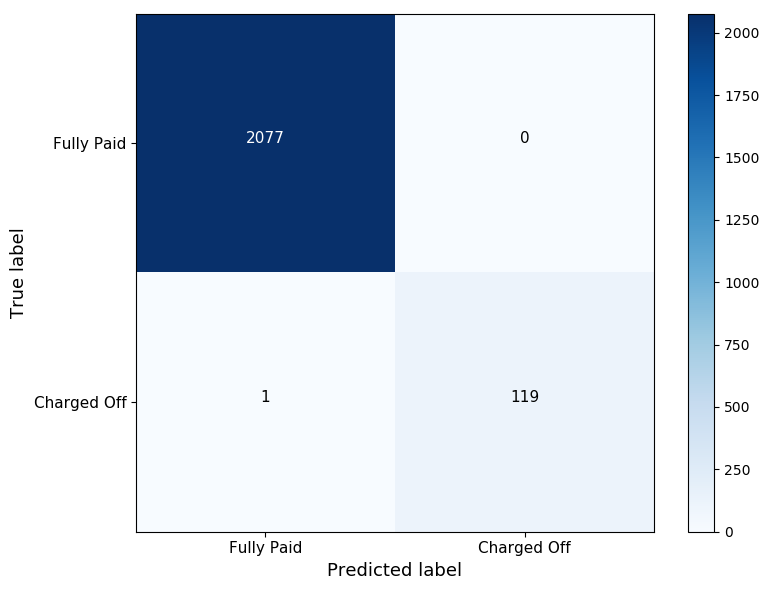

In [56]:
# model build and prediction
m = RandomForestClassifier(random_state=42)
m.fit(trainX, trainY)
predY = m.predict(testX)
evaluation(testY, predY)

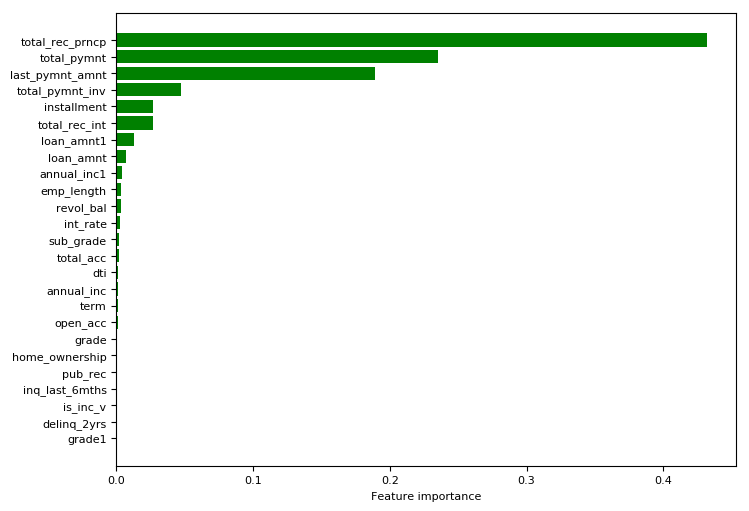

In [57]:
# Check feature importances
features = X.columns.tolist()
features_importances = m.feature_importances_
indices = np.argsort(features_importances)

pl.barh(range(len(features)), features_importances[indices],color='green')
pl.yticks(range(len(features)), [features[i] for i in indices])
pl.xlabel('Feature importance', fontsize=8)
pl.tick_params(axis='both', labelsize=8)